In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/common-voice/cv-other-train.csv
/kaggle/input/common-voice/cv-invalid.csv
/kaggle/input/common-voice/cv-valid-dev.csv
/kaggle/input/common-voice/README.txt
/kaggle/input/common-voice/cv-valid-train.csv
/kaggle/input/common-voice/LICENSE.txt
/kaggle/input/common-voice/cv-valid-test.csv
/kaggle/input/common-voice/cv-other-dev.csv
/kaggle/input/common-voice/cv-other-test.csv
/kaggle/input/common-voice/cv-valid-test/cv-valid-test/sample-000422.mp3
/kaggle/input/common-voice/cv-valid-test/cv-valid-test/sample-000497.mp3
/kaggle/input/common-voice/cv-valid-test/cv-valid-test/sample-000446.mp3
/kaggle/input/common-voice/cv-valid-test/cv-valid-test/sample-000912.mp3
/kaggle/input/common-voice/cv-valid-test/cv-valid-test/sample-001249.mp3
/kaggle/input/common-voice/cv-valid-test/cv-valid-test/sample-003643.mp3
/kaggle/input/common-voice/cv-valid-test/cv-valid-test/sample-003434.mp3
/kaggle/input/common-voice/cv-valid-test/cv-valid-test/sample-002783.mp3
/kaggle/input/common-voice/

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from pydub import AudioSegment
from scipy.io import wavfile
from tempfile import mktemp
from pydub import AudioSegment
import IPython
import librosa
import IPython.display as ipd
import librosa.display
# plt.figure(figsize=(15,4))
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import RepeatedStratifiedKFold

2024-05-11 12:49:37.097974: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 12:49:37.098128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 12:49:37.284197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('../input/common-voice/cv-valid-train.csv')

In [3]:
df.head()

filename  \
0  cv-valid-train/sample-000000.mp3   
1  cv-valid-train/sample-000001.mp3   
2  cv-valid-train/sample-000002.mp3   
3  cv-valid-train/sample-000003.mp3   
4  cv-valid-train/sample-000004.mp3   

                                                text  up_votes  down_votes  \
0  learn to recognize omens and follow them the o...         1           0   
1         everything in the universe evolved he said         1           0   
2  you came so that you could learn about your dr...         1           0   
3  so now i fear nothing because it was those ome...         1           0   
4  if you start your emails with greetings let me...         3           2   

   age gender accent  duration  
0  NaN    NaN    NaN       NaN  
1  NaN    NaN    NaN       NaN  
2  NaN    NaN    NaN       NaN  
3  NaN    NaN    NaN       NaN  
4  NaN    NaN    NaN       NaN

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195776 entries, 0 to 195775
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   filename    195776 non-null  object 
 1   text        195776 non-null  object 
 2   up_votes    195776 non-null  int64  
 3   down_votes  195776 non-null  int64  
 4   age         73768 non-null   object 
 5   gender      74059 non-null   object 
 6   accent      64711 non-null   object 
 7   duration    0 non-null       float64
dtypes: float64(1), int64(2), object(5)
memory usage: 11.9+ MB


In [5]:
df.isna().sum()

filename           0
text               0
up_votes           0
down_votes         0
age           122008
gender        121717
accent        131065
duration      195776
dtype: int64

In [6]:
df.drop('duration',axis=1,inplace=True)
df.shape

(195776, 7)

In [7]:
data=df[(df.age.notna())&(df.gender.notna())]
data.shape

(73466, 7)

# Exploratory Data Analysis

In [8]:
age_count=data.groupby(['age','gender']).agg({'filename':'count'}).reset_index()
fig = px.bar(age_count, x="age", y="filename", color="gender", title="Count files by age",text_auto=True).update_xaxes(categoryorder="total descending")
fig.show()

In [9]:
gender_count=data.groupby('gender').agg({'filename':'count'}).reset_index()
fig = px.bar(gender_count, x="gender", y="filename",  title="Count files by gender",text_auto=True).update_xaxes(categoryorder="total descending")
fig.show()

In [10]:
accent_count=data.groupby(['accent','gender']).agg({'filename':'count'}).reset_index()
fig = px.bar(accent_count, x="accent", y="filename", color='gender', title="Count files by accent",text_auto=True).update_xaxes(categoryorder="total descending")
fig.show()

In [11]:
accent_count=data.groupby(['accent','age']).agg({'filename':'count'}).reset_index()
fig = px.bar(accent_count, x="accent", y="filename", color='age', title="Count files by accent",text_auto=True).update_xaxes(categoryorder="total descending")
fig.show()

In [12]:
path =['../input/common-voice/cv-valid-train/'+path for path in data.filename]
sr = 22050 # sample rate
IPython.display.Audio(path[1], rate=sr)

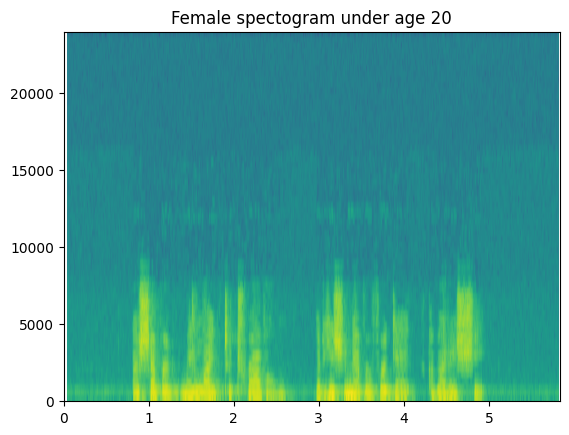

In [13]:
mp3_audio = AudioSegment.from_file(path[0], format="mp3")  # read mp3
wname = mktemp('.wav')  # use temporary file
mp3_audio.export(wname, format="wav")  # convert to wav
FS, ds = wavfile.read(wname)  # read wav file
plt.specgram(ds, Fs=FS, NFFT=128, noverlap=0)  # plot
plt.title('Female spectogram under age 20')
plt.show()

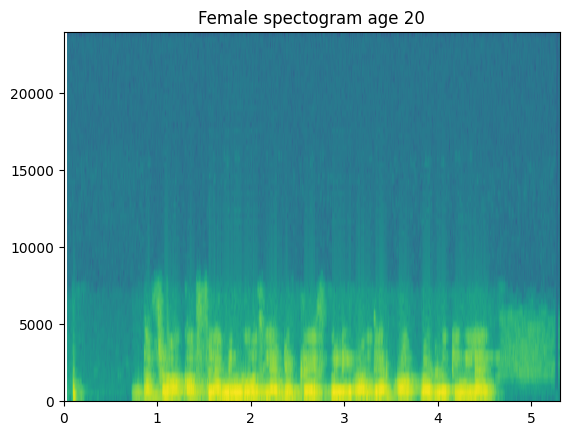

In [14]:
mp3_audio = AudioSegment.from_file(path[26], format="mp3")  # read mp3
wname = mktemp('.wav')  # use temporary file
mp3_audio.export(wname, format="wav")  # convert to wav
FS, ds = wavfile.read(wname)  # read wav file
plt.specgram(ds, Fs=FS, NFFT=128, noverlap=0)  # plot
plt.title('Female spectogram age 20')
plt.show()

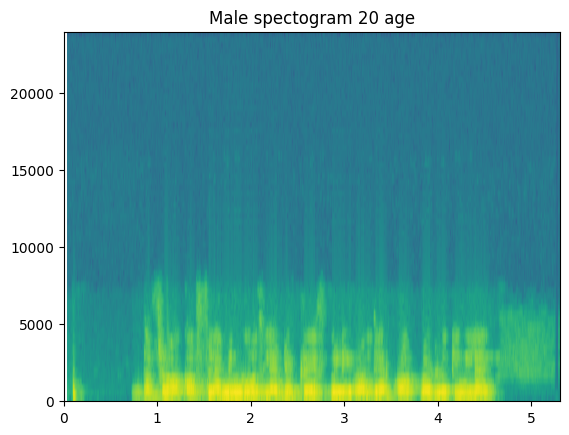

In [15]:
mp3_audio = AudioSegment.from_file(path[26], format="mp3")  # read mp3
wname = mktemp('.wav')  # use temporary file
mp3_audio.export(wname, format="wav")  # convert to wav
FS, ds = wavfile.read(wname)  # read wav file
plt.specgram(ds, Fs=FS, NFFT=128, noverlap=0)  # plot
plt.title('Male spectogram 20 age')
plt.show()

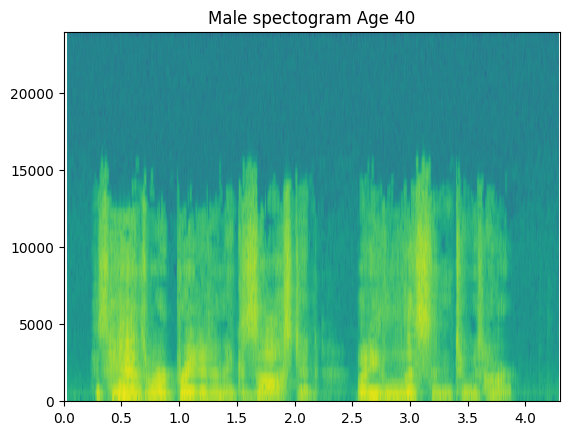

In [16]:
mp3_audio = AudioSegment.from_file(path[42], format="mp3")  # read mp3
wname = mktemp('.wav')  # use temporary file
mp3_audio.export(wname, format="wav")  # convert to wav
FS, ds = wavfile.read(wname)  # read wav file
plt.specgram(ds, Fs=FS, NFFT=128, noverlap=0)  # plot
plt.title('Male spectogram Age 40')
plt.show()

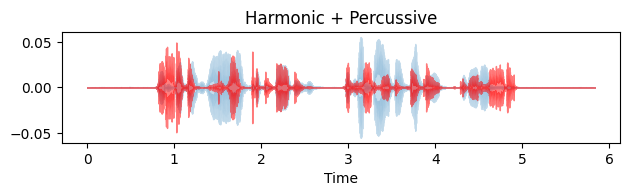

In [17]:
y, sr = librosa.load(path[0], duration=10)
y_harm, y_perc = librosa.effects.hpss(y)
plt.subplot(3, 1, 3)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.25)
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5)
plt.title('Harmonic + Percussive')
plt.tight_layout()
plt.show()

# Normalization

In [18]:
cleanup_nums = {"teens":0.0,"twenties":1.0,"thirties":2.0,"fourties":3.0,"fifties":4.0,"sixties":5.0,"seventies":6.0,"twenties":7.0,"eighties":8.0}
data.age = data.age.map(cleanup_nums)
data = data[:1000]
data.head()

filename  \
5   cv-valid-train/sample-000005.mp3   
8   cv-valid-train/sample-000008.mp3   
13  cv-valid-train/sample-000013.mp3   
14  cv-valid-train/sample-000014.mp3   
19  cv-valid-train/sample-000019.mp3   

                                                 text  up_votes  down_votes  \
5   a shepherd may like to travel but he should ne...         1           0   
8                       put jackie right on the staff         3           0   
13  but he had found a guide and didn't want to mi...         1           0   
14  as they began to decorate the hallway a silhou...         1           0   
19   then they got ahold of some dough and went goofy         1           0   

    age  gender     accent  
5   7.0  female         us  
8   6.0    male         us  
13  2.0  female         us  
14  5.0    male    england  
19  4.0    male  australia

# Feature Extraction

In [19]:
ds_path = "/kaggle/input/common-voice/cv-valid-train/"

#this function is used to extract audio frequency features
def feature_extraction(filename, sampling_rate=48000):
    path = "{}{}".format(ds_path, filename)
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    gender = data[data['filename'] == filename].gender.values[0]
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features
    
        
features = feature_extraction(data.iloc[0]['filename'])
print("features: ", features)

features:  ['female', 2147.6058803589067, 2430.4749711924064, 4428.830553016453, -625.28143, 111.306145, 6.3690844, 34.7671, 31.623457, -4.7215633, -0.5119338, -4.9454904, -12.71285, -2.0436714, -3.7277248, -10.708404, -11.206563, -12.003516, -8.506438, -5.472296, -4.950396, -3.7100525, -6.3149858, -6.328086]


In [20]:
def create_df_features(orig):
    new_rows = list()
    tot_rows = len(orig)-1
    stop_counter = 1000
    
    for idx, row in orig.iterrows():
        if idx >= stop_counter: break
        print("\r", end="")
        print("{}/{}".format(idx, tot_rows), end="", flush=True)
        features = feature_extraction(row['filename'])
        features.append(row['age'])
        new_rows.append(features)

    return pd.DataFrame(new_rows, columns=["label", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
                                    "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                                   "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                                   "mfcc17", "mfcc18", "mfcc19", "mfcc20", "age"])

df_features = create_df_features(data)
df_features.head()e

999/999

label  spectral_centroid  spectral_bandwidth  spectral_rolloff  \
0  female        2147.605880         2430.474971       4428.830553   
1    male        2815.325440         2451.922347       4884.633819   
2  female        1844.637736         1491.011525       3164.948048   
3    male        2123.711334         2202.012929       4111.215965   
4    male        2360.672043         2957.220239       4767.080050   

        mfcc1       mfcc2      mfcc3      mfcc4      mfcc5      mfcc6  ...  \
0 -625.281433  111.306145   6.369084  34.767101  31.623457  -4.721563  ...   
1 -469.936646  126.283386 -16.548647   3.546792   2.184188  13.748076  ...   
2 -418.205475  147.666870 -49.974003  -2.286364  37.185310  -8.906048  ...   
3 -464.910706  118.437225  19.749662  27.143229  26.438824   2.309232  ...   
4 -343.833008  157.153885   7.661150  41.898964 -15.152472  28.925106  ...   

      mfcc12     mfcc13     mfcc14    mfcc15    mfcc16    mfcc17    mfcc18  \
0 -10.708404 -11.206563 -12.003516 -8.506438 -5.472296 -4.950396 -3.710052   
1 -10.987889   1.132519   6.090082 -1.732454 -1.226424 -6.432128 -7.269326   
2 -13.844883  -9.928527  -7.873624 -5.476491 -2.298846 -6.556987 -5.206550   
3  -5.461425  -2.908412  -4.496075 -2.716447 -0.080573 -5.294940 -5.868721   
4   0.102647   6.319802  -1.603871  3.837120 -2.643298  2.323318 -1.382684   

     mfcc19    mfcc20  age  
0 -6.314986 -6.328086  7.0  
1 -4.796600 -3.129156  6.0  
2 -0.403855 -3.877070  2.0  
3  0.600507 -3.375832  5.0  
4  3.791498 -3.534383  4.0  

[5 rows x 25 columns]

In [21]:
df_features.shape

(357, 25)

In [22]:
df_features.iloc[:,1:]

spectral_centroid  spectral_bandwidth  spectral_rolloff       mfcc1  \
0          2147.605880         2430.474971       4428.830553 -625.281433   
1          2815.325440         2451.922347       4884.633819 -469.936646   
2          1844.637736         1491.011525       3164.948048 -418.205475   
3          2123.711334         2202.012929       4111.215965 -464.910706   
4          2360.672043         2957.220239       4767.080050 -343.833008   
..                 ...                 ...               ...         ...   
352        2983.523078         3094.703664       5589.813312 -352.644806   
353        2174.887701         2679.056729       4868.085020 -570.829163   
354        3512.329185         2492.712529       5920.179835 -497.951660   
355        2375.653025         2886.649527       5052.825218 -355.934692   
356        1479.309626         1544.828870       2616.843750 -548.276123   

          mfcc2      mfcc3      mfcc4      mfcc5      mfcc6      mfcc7  ...  \
0    111.306145   6.369084  34.767101  31.623457  -4.721563  -0.511934  ...   
1    126.283386 -16.548647   3.546792   2.184188  13.748076  -1.324955  ...   
2    147.666870 -49.974003  -2.286364  37.185310  -8.906048 -14.228477  ...   
3    118.437225  19.749662  27.143229  26.438824   2.309232  -9.353925  ...   
4    157.153885   7.661150  41.898964 -15.152472  28.925106   0.091127  ...   
..          ...        ...        ...        ...        ...        ...  ...   
352  111.333778  10.970480  43.019562  -5.845692  33.565289   5.517570  ...   
353   91.832573  26.260775  24.649992  13.757536   9.347327  15.685637  ...   
354   90.748756 -26.420492  26.557692  -2.167530  -4.835798 -11.169948  ...   
355  149.844788  14.244913 -13.874662  -9.765439   5.608142  -2.801700  ...   
356  125.926468  55.874218  20.370941  -4.590322 -18.492918 -10.376763  ...   

        mfcc12     mfcc13     mfcc14    mfcc15    mfcc16    mfcc17    mfcc18  \
0   -10.708404 -11.206563 -12.003516 -8.506438 -5.472296 -4.950396 -3.710052   
1   -10.987889   1.132519   6.090082 -1.732454 -1.226424 -6.432128 -7.269326   
2   -13.844883  -9.928527  -7.873624 -5.476491 -2.298846 -6.556987 -5.206550   
3    -5.461425  -2.908412  -4.496075 -2.716447 -0.080573 -5.294940 -5.868721   
4     0.102647   6.319802  -1.603871  3.837120 -2.643298  2.323318 -1.382684   
..         ...        ...        ...       ...       ...       ...       ...   
352  -6.127451  -2.963707 -12.510113 -4.818301  4.900295 -0.968318 -3.085257   
353  -0.538661   3.222944   0.328055 -0.565113 -0.672413 -5.595410 -3.799350   
354  -1.419197 -13.769631  -6.574073 -2.151672 -7.799372 -1.841459 -1.204205   
355   1.822158   3.203999 -10.517605 -4.719309 -0.874566  3.128178  1.700097   
356 -13.269221 -10.650457  -5.746386 -3.244497 -0.874257 -0.935079 -1.158919   

       mfcc19     mfcc20  age  
0   -6.314986  -6.328086  7.0  
1   -4.796600  -3.129156  6.0  
2   -0.403855  -3.877070  2.0  
3    0.600507  -3.375832  5.0  
4    3.791498  -3.534383  4.0  
..        ...        ...  ...  
352  4.961952  -6.900348  7.0  
353 -0.084547  -1.919119  3.0  
354 -7.670021  -3.062324  3.0  
355 -1.749669 -10.464507  7.0  
356 -0.144602  -0.790416  2.0  

[357 rows x 24 columns]

In [23]:
from sklearn.preprocessing import StandardScaler
data = df_features.iloc[:,1:]
scaler = StandardScaler()
df_features.iloc[:,1:]=scaler.fit_transform(data)

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_features['label']=le.fit_transform(df_features.label)

In [25]:
df_features

label  spectral_centroid  spectral_bandwidth  spectral_rolloff     mfcc1  \
0        0          -0.621387           -0.051841         -0.350453 -2.160970   
1        1           0.199233           -0.018323         -0.052514 -0.385870   
2        0          -0.993732           -1.520029         -1.176597  0.205254   
3        1          -0.650753           -0.408880         -0.558064 -0.328439   
4        1          -0.359531            0.771354         -0.129354  1.055097   
..     ...                ...                 ...               ...       ...   
352      1           0.405947            0.986212          0.408431  0.954406   
353      1          -0.587858            0.336641         -0.063331 -1.538753   
354      0           1.055844            0.045423          0.624377 -0.705993   
355      1          -0.341120            0.661066          0.057425  0.916813   
356      1          -1.442716           -1.435924         -1.534869 -1.281043   

        mfcc2     mfcc3     mfcc4     mfcc5     mfcc6  ...    mfcc12  \
0   -0.350479  0.572052  0.784067  1.512509 -0.810476  ... -1.175973   
1    0.231574 -0.595247 -1.280478 -0.553798  0.483127  ... -1.227829   
2    1.062589 -2.297745 -1.666215  1.902888 -1.103554  ... -1.757920   
3   -0.073348  1.253583  0.279913  1.148605 -0.318043  ... -0.202440   
4    1.431278  0.637862  1.255685 -1.770637  1.546117  ...  0.829927   
..        ...       ...       ...       ...       ...  ...       ...   
352 -0.349405  0.806421  1.329788 -1.117406  1.871113  ... -0.326016   
353 -1.107271  1.585222  0.115040  0.258521  0.174901  ...  0.710937   
354 -1.149390 -1.098063  0.241193 -0.859240 -0.818477  ...  0.547561   
355  1.147229  0.973202 -2.432529 -1.392528 -0.086989  ...  1.148968   
356  0.217703  3.093562 -0.167926 -1.029293 -1.775013  ... -1.651111   

       mfcc13    mfcc14    mfcc15    mfcc16    mfcc17    mfcc18    mfcc19  \
0   -1.709095 -1.229283 -1.119748 -0.694711 -0.306114 -0.461898 -1.087603   
1    0.625912  2.331136  0.250050  0.306106 -0.666298 -1.393143 -0.747568   
2   -1.467244 -0.416612 -0.507049  0.053320 -0.696649 -0.853440  0.236165   
3   -0.138781  0.248015  0.051072  0.576201 -0.389867 -1.026690  0.461086   
4    1.607536  0.817137  1.376299 -0.027873  1.462001  0.147033  1.175693   
..        ...       ...       ...       ...       ...       ...       ...   
352 -0.149244 -1.328970 -0.373953  1.750267  0.661861 -0.298427  1.437810   
353  1.021497  1.197297  0.486103  0.436695 -0.462906 -0.485262  0.307672   
354 -2.194122 -0.160889  0.165278 -1.243238  0.449615  0.193730 -1.391056   
355  1.017912 -0.936889 -0.353935  0.389044  1.657649  0.953609 -0.065224   
356 -1.603860  0.001982 -0.055707  0.389117  0.669941  0.205579  0.294223   

       mfcc20       age  
0   -0.662133  1.266516  
1    0.311574  0.831341  
2    0.083920 -0.909356  
3    0.236489  0.396167  
4    0.188229 -0.039007  
..        ...       ...  
352 -0.836321  1.266516  
353  0.679891 -0.474182  
354  0.331916 -0.474182  
355 -1.921198  1.266516  
356  1.023451 -0.909356  

[357 rows x 25 columns]

In [26]:
x = df_features.iloc[:,1:]
y = df_features['label']

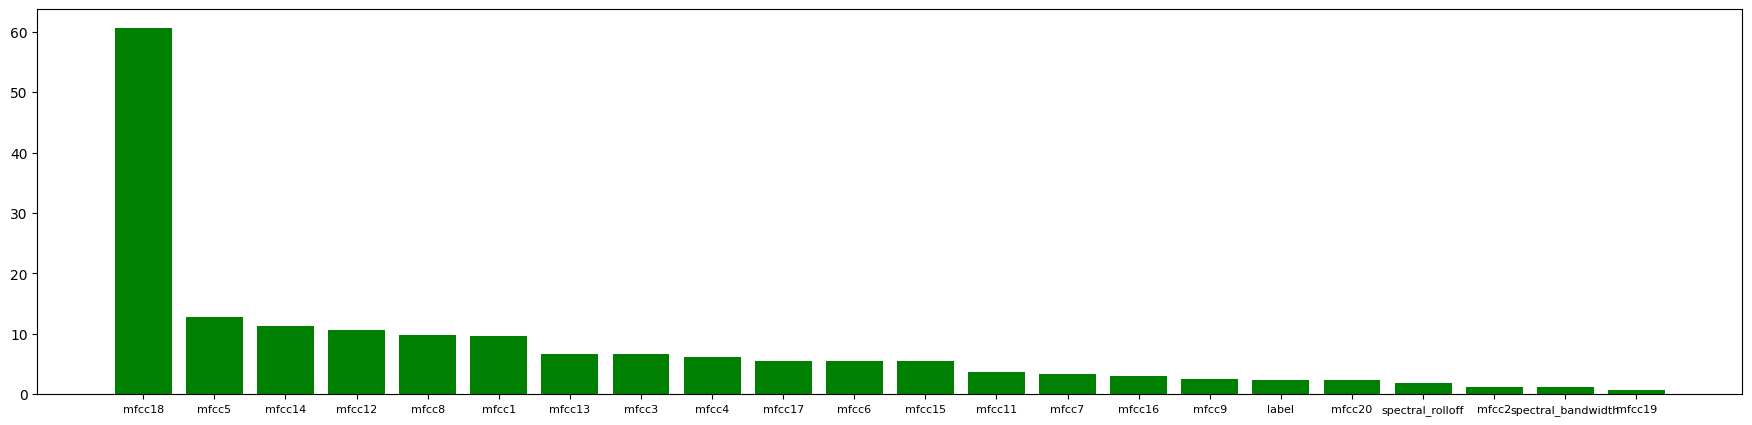

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

n_features = 22

f_selector = SelectKBest(f_classif, k=n_features).fit(x, y)
X_new = f_selector.transform(x)
scores = f_selector.scores_

indices = np.argsort(scores)[::-1]

features = []
for i in range(n_features):
    features.append(df_features.columns[indices[i]])
    
plt.figure(figsize=(22, 5))
plt.bar(features, scores[indices[range(n_features)]], color='g')
plt.xticks(fontsize=8)
plt.show()

In [28]:
def target_coeff(dataframe,target):
    data = dataframe.corr()[target].sort_values(ascending=False)
    indices = data.index
    labels = []
    corr = []
    for i in range(1, len(indices)):
        labels.append(indices[i])
        corr.append(data[i])
    plt.figure(figsize=(10,8),dpi=100)    
    sns.barplot(x=corr, y=labels, palette="RdBu")
    plt.title('Correlation Coefficient for : {} column'.format(target.upper()))
    plt.show()

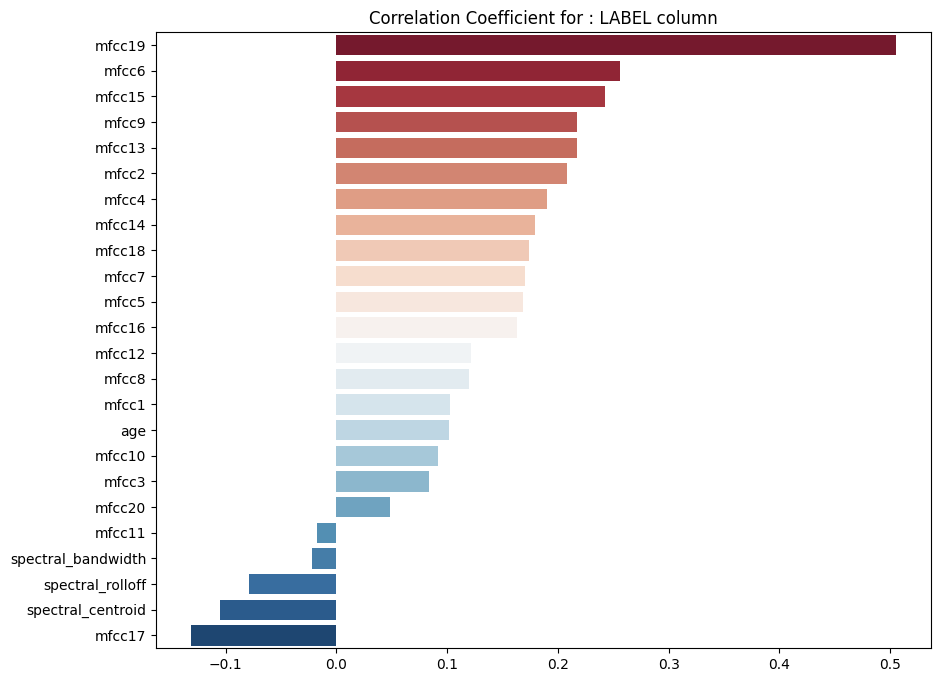

In [29]:
target_coeff(df_features,'label')

In [31]:
fig = px.scatter(df_features, x="mfcc19", y="mfcc6",  color="label",
                 hover_data=['label'])
fig.show()

In [32]:
fig = px.scatter(df_features, x="mfcc19", y="mfcc9",  color="label",
                 hover_data=['label'])
fig.show()

In [33]:
fig = px.scatter(df_features, x="mfcc19", y="mfcc6",  color="label",
                 hover_data=['label'])
fig.show()

In [34]:
fig = px.scatter(df_features, x="spectral_centroid", y="spectral_rolloff",  color="label",
                 hover_data=['label'])
fig.show()

In [35]:
fig = px.scatter(df_features, x="spectral_centroid", y="spectral_bandwidth",  color="label",
                 hover_data=['label'])
fig.show()

In [36]:
fig = px.scatter(df_features, x="spectral_bandwidth", y="spectral_rolloff",  color="label",
                 hover_data=['label'])
fig.show()

In [37]:
def distribution(x,title):
    plt.figure(figsize=(15,6))
    ax = sns.distplot(x, kde=False,bins=30)
    values = np.array([rec.get_height() for rec in ax.patches])
    norm = plt.Normalize(values.min(), values.max())
    colors = plt.cm.jet(norm(values))
    for rec, col in zip(ax.patches,colors):
        rec.set_color(col)
    plt.title(title, size=20, color='black')

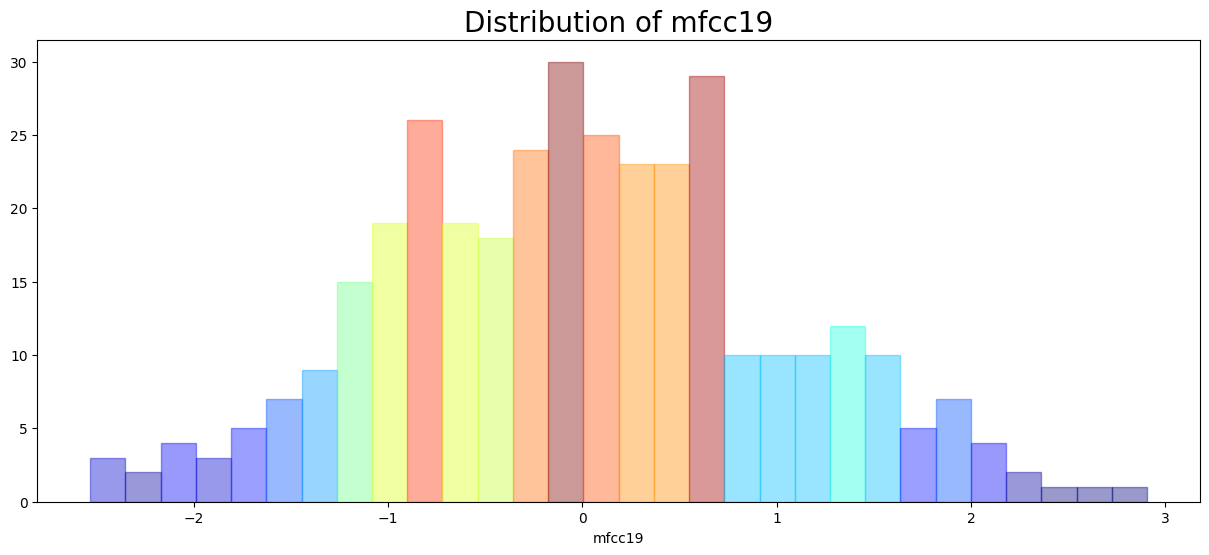

In [38]:
distribution(df_features.mfcc19,'Distribution of mfcc19')

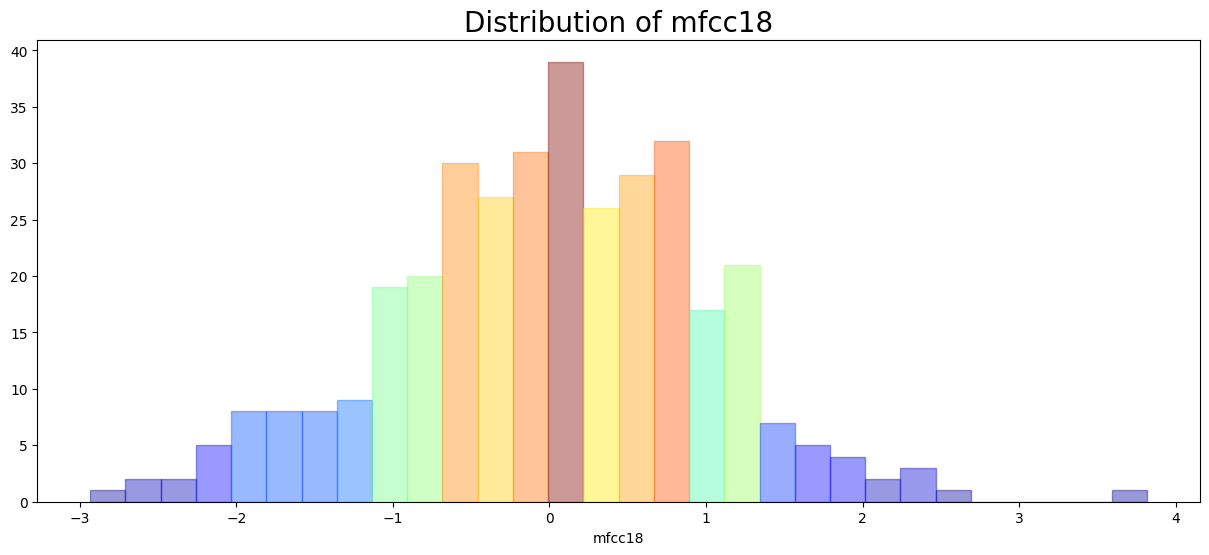

In [39]:
distribution(df_features.mfcc18,'Distribution of mfcc18')

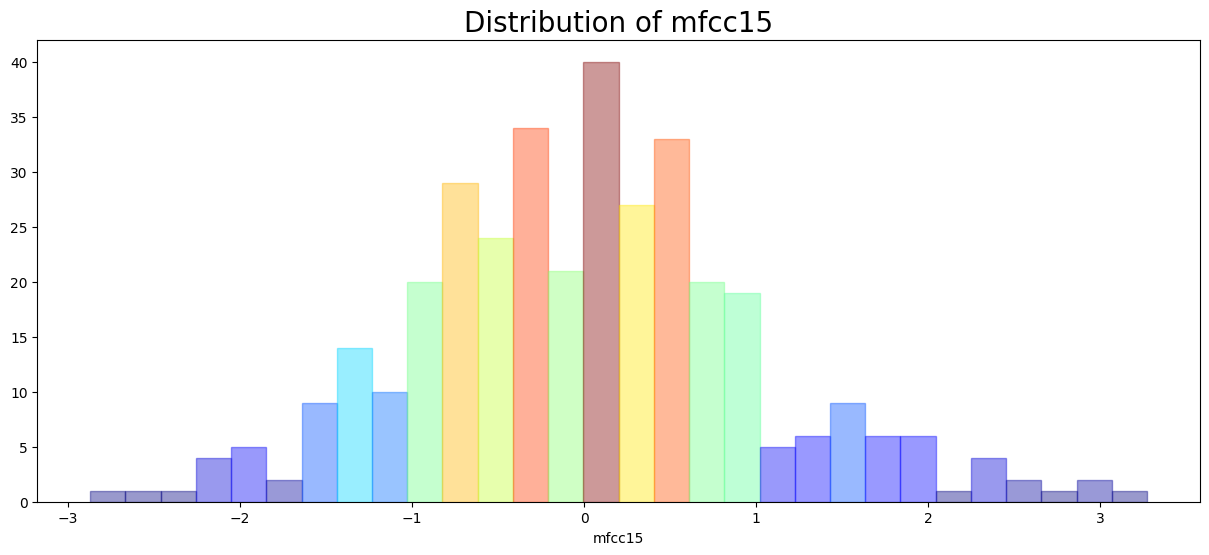

In [40]:
distribution(df_features.mfcc15,'Distribution of mfcc15')

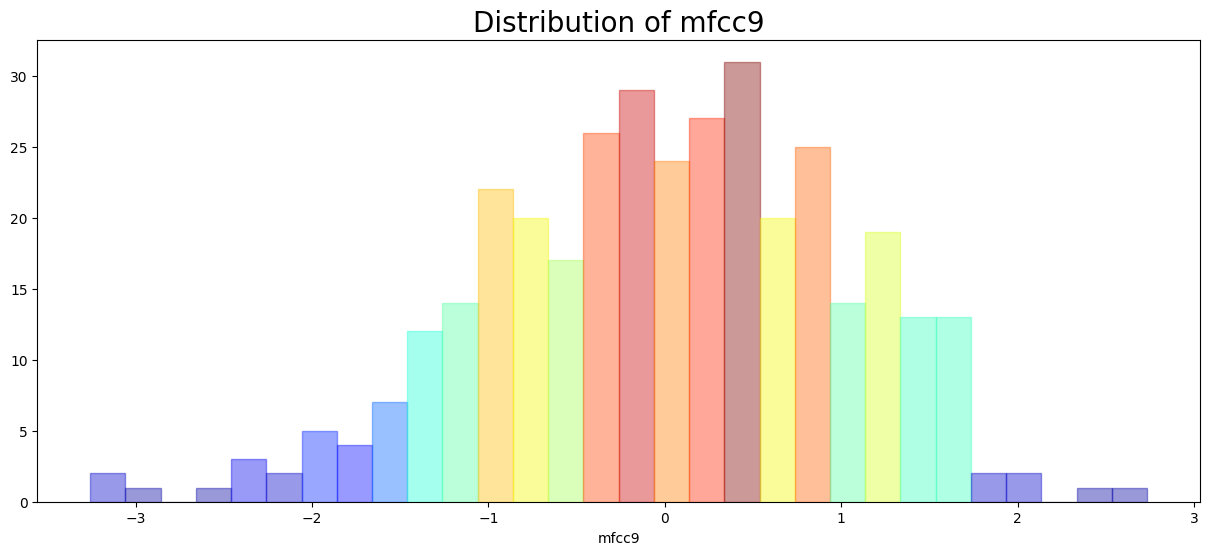

In [42]:
distribution(df_features.mfcc9,'Distribution of mfcc9')

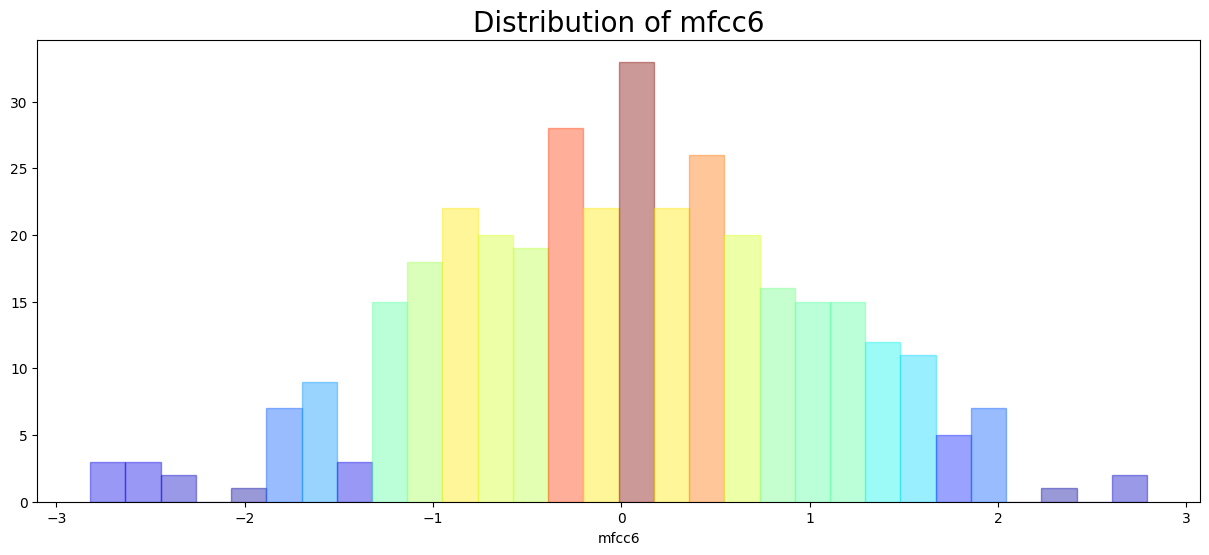

In [43]:
distribution(df_features.mfcc6,'Distribution of mfcc6')

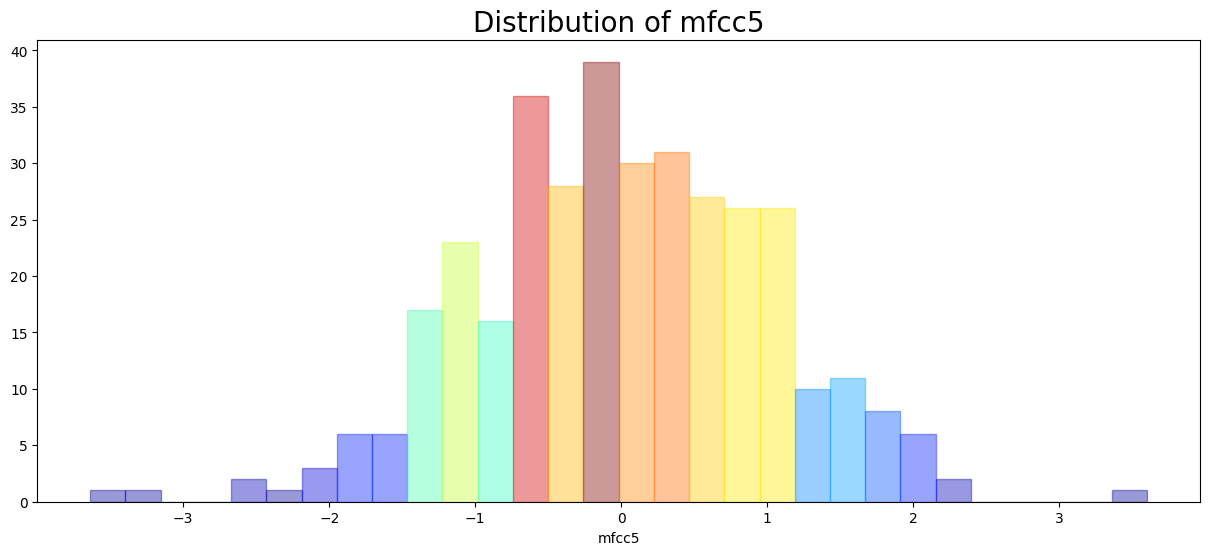

In [44]:
distribution(df_features.mfcc5,'Distribution of mfcc5')

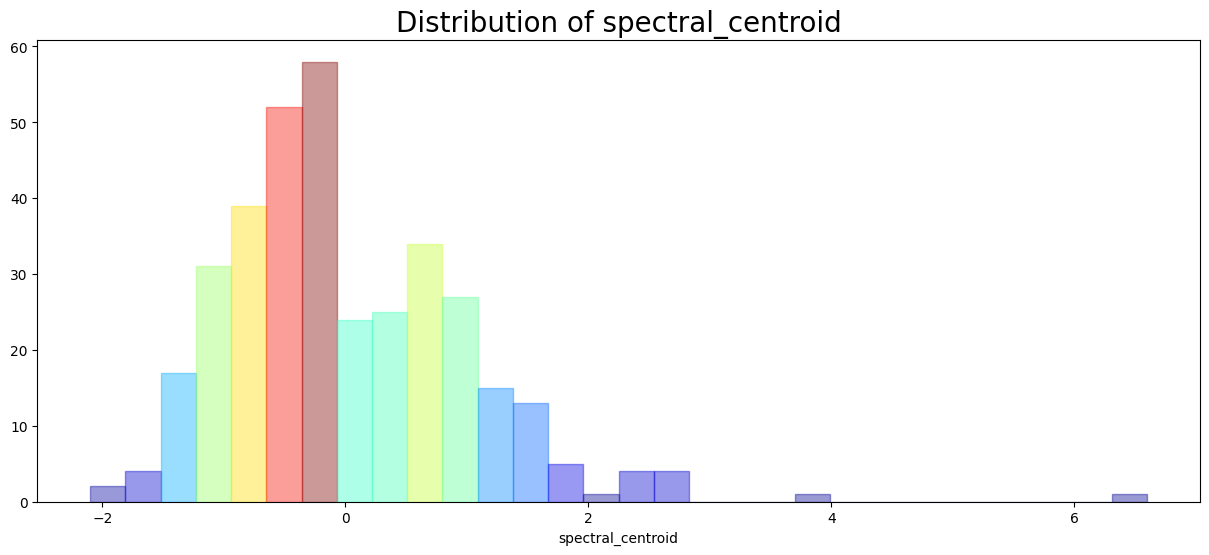

In [45]:
distribution(df_features.spectral_centroid,'Distribution of spectral_centroid')

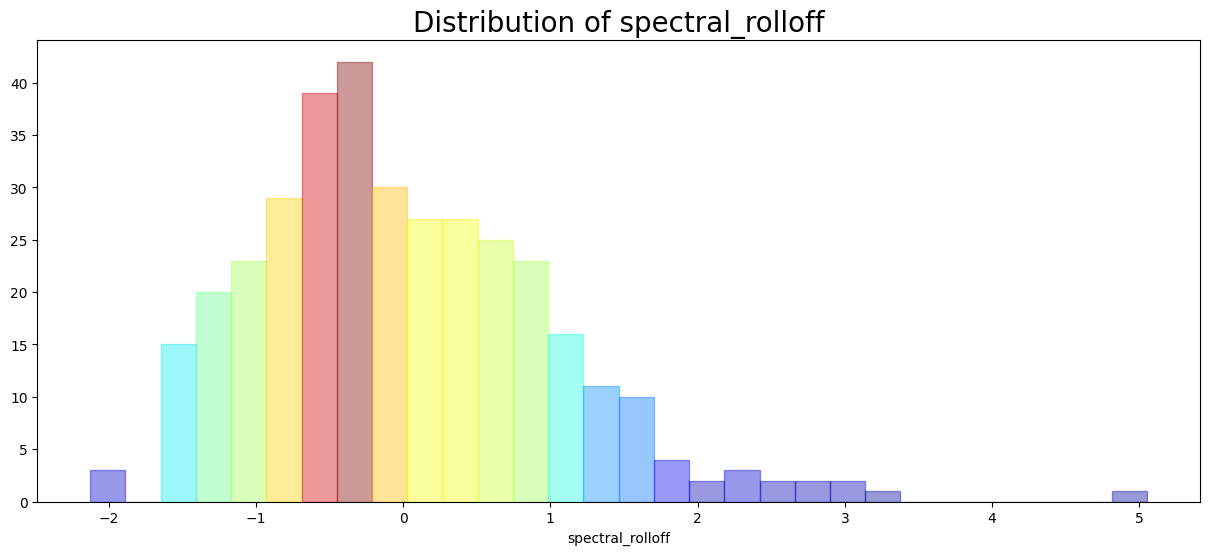

In [46]:
distribution(df_features.spectral_rolloff,'Distribution of spectral_rolloff')

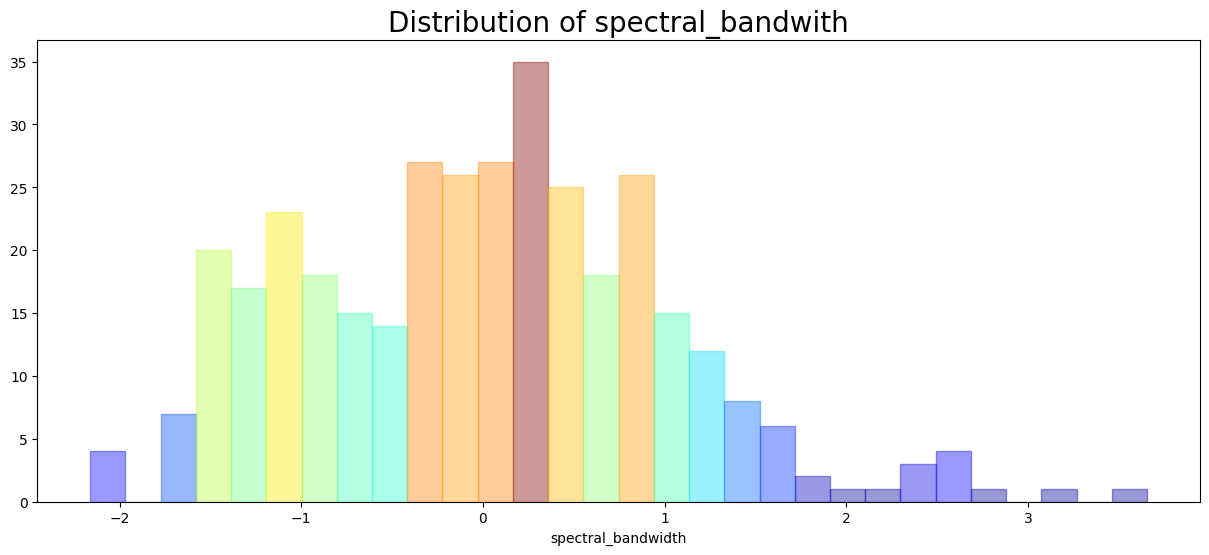

In [47]:
distribution(df_features.spectral_bandwidth,'Distribution of spectral_bandwith')

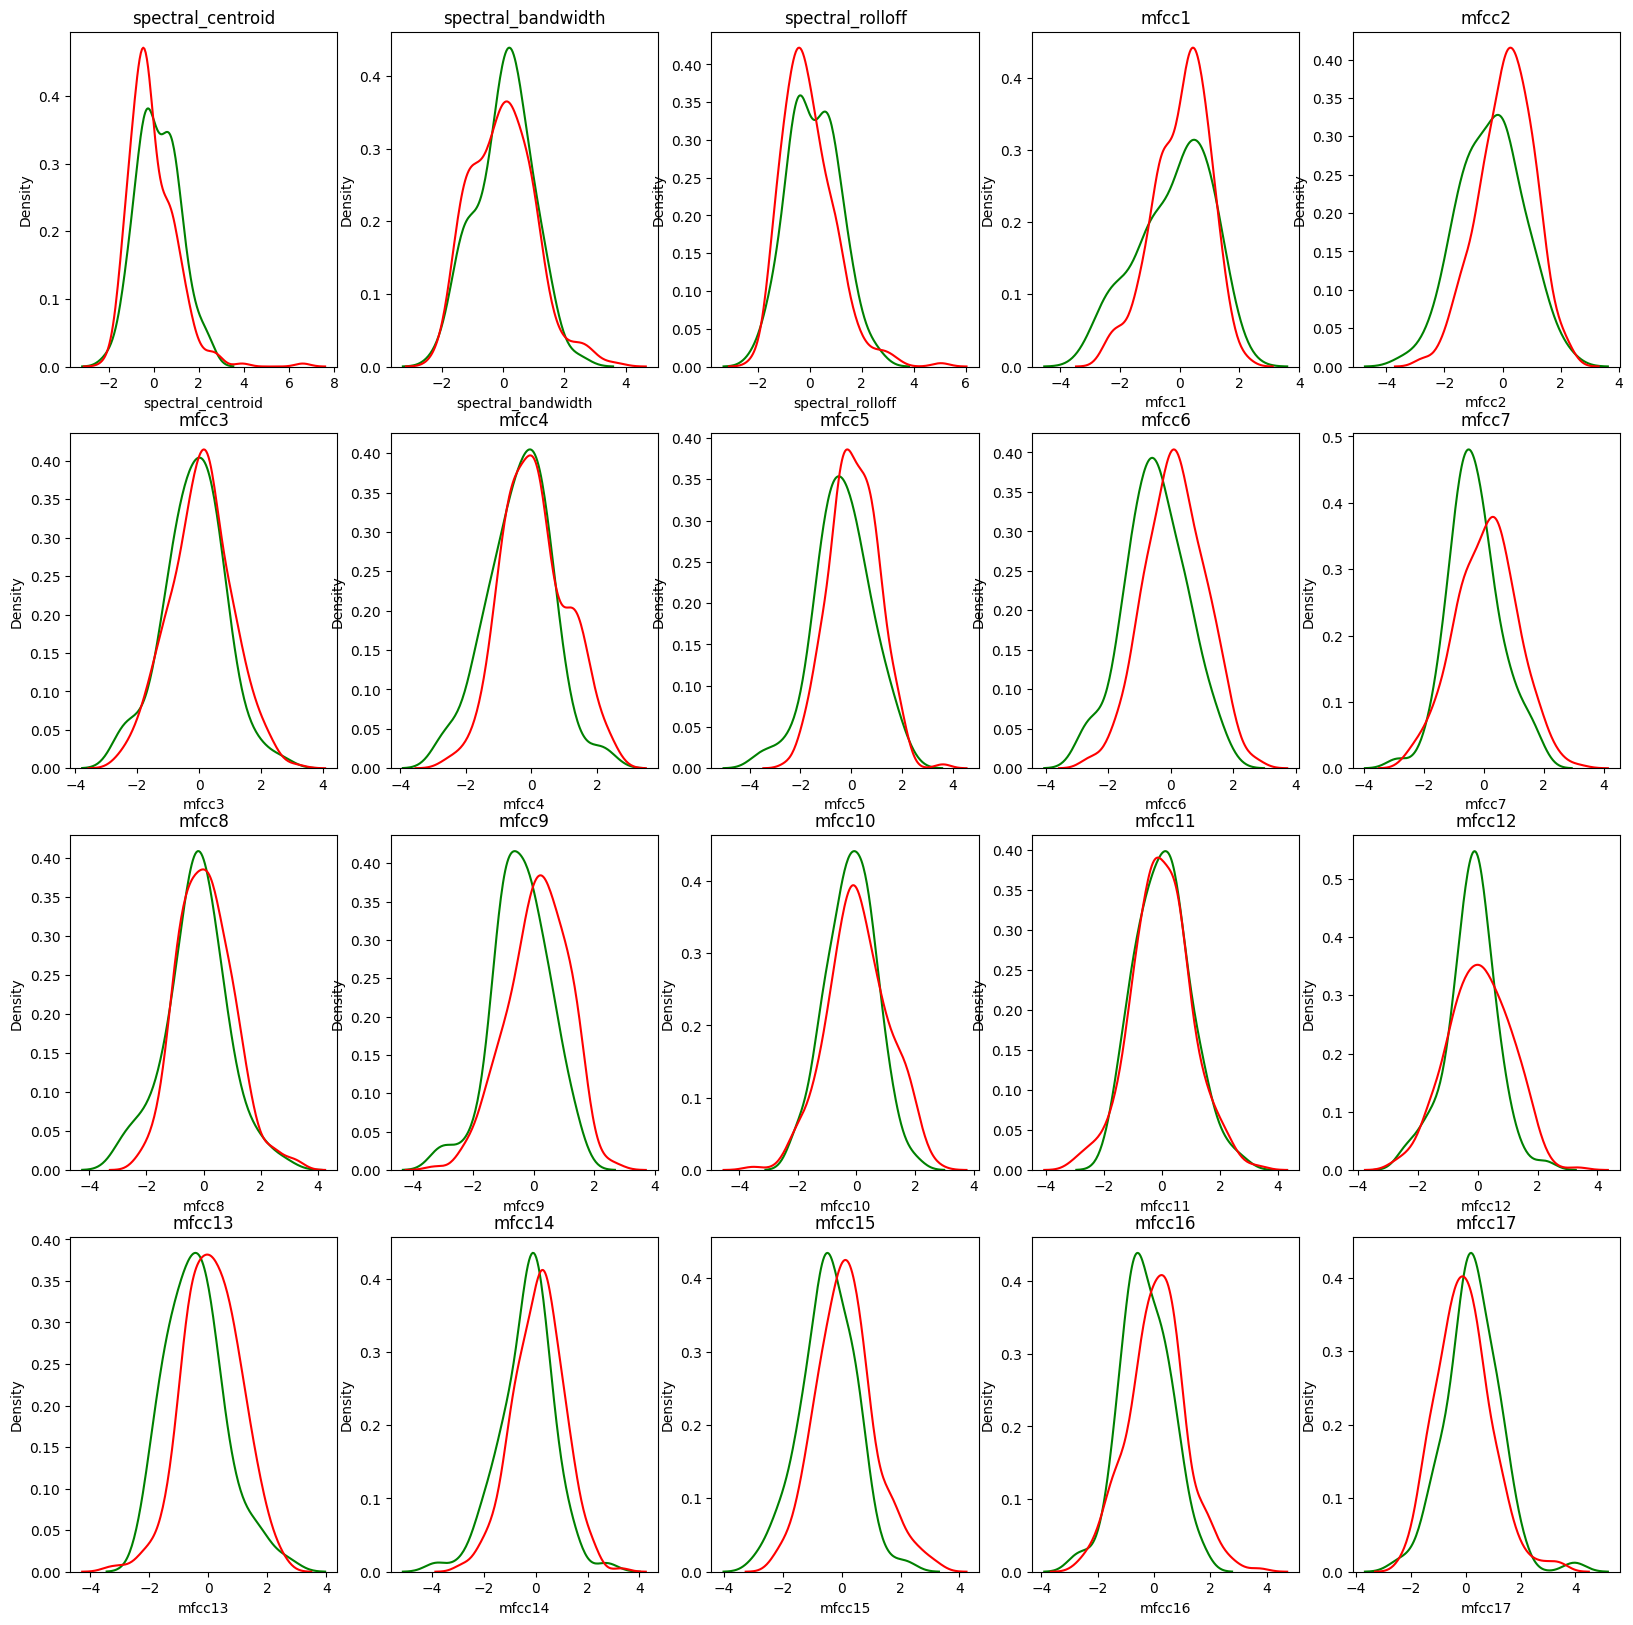

In [48]:
plt.subplots(4,5,figsize=(20,20))
for k in range(1,21):
    plt.subplot(4,5,k)
    plt.title(df_features.columns[k])
    sns.kdeplot(df_features.loc[df_features['label'] == 0, df_features.columns[k]], color= 'green', label='F')
    sns.kdeplot(df_features.loc[df_features['label'] == 1, df_features.columns[k]], color= 'red', label='M')

In [49]:
X = df_features.iloc[:,1:]
y = df_features.label
rskf = RepeatedStratifiedKFold(n_splits=5,
                                   n_repeats=3,
                                   random_state=42)

lst_accu_stratified = []
for train_index, test_index in rskf.split(X, y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [50]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

classifiers_and_params = [
    (SVC(), {'C': [200, 150, 100], 'gamma': ['auto', 'scale']}),
    (RandomForestClassifier(), {'n_estimators': [100, 150, 200]})
]

for tup in classifiers_and_params:
    print("{}".format(tup[0].__class__.__name__))
    
    # the main CV process
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)
    fold_counter = 0

    results = list()
    for train_idx, test_idx in outer_cv.split(X_new):
        fold_counter += 1
        
        # split data in training and test sets
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # the CV process used for the Grid Search
        inner_cv = KFold(n_splits=2, shuffle=True, random_state=0)

        # define and run the Grid Search CV process
        gs = GridSearchCV(tup[0], tup[1], scoring='f1_macro', cv=inner_cv, refit=True)
        res = gs.fit(X_train, y_train)

        # get the best model, re-fit on the whole training set
        best_model = res.best_estimator_

        # evaluation on the test set
        pred = best_model.predict(X_test)
        score = f1_score(y_test, pred, average='macro')
        results.append(score)
        
        print("\tFold {}, Best Params {} with F1 Score {:.3f}, F1 Score on Test data {:.3f}"
              .format(fold_counter, res.best_params_, res.best_score_, score))

    print('\tAverage F1 Score on Test Set: {:.3f}\n'.format(np.mean(results)))

SVC
	Fold 1, Best Params {'C': 200, 'gamma': 'auto'} with F1 Score 0.675, F1 Score on Test data 0.497
	Fold 2, Best Params {'C': 200, 'gamma': 'auto'} with F1 Score 0.624, F1 Score on Test data 0.784
	Fold 3, Best Params {'C': 200, 'gamma': 'auto'} with F1 Score 0.546, F1 Score on Test data 0.784
	Average F1 Score on Test Set: 0.689

RandomForestClassifier
	Fold 1, Best Params {'n_estimators': 150} with F1 Score 0.614, F1 Score on Test data 0.532
	Fold 2, Best Params {'n_estimators': 200} with F1 Score 0.625, F1 Score on Test data 0.699
	Fold 3, Best Params {'n_estimators': 100} with F1 Score 0.559, F1 Score on Test data 0.730
	Average F1 Score on Test Set: 0.654

